```
This software is part of GPU Ocean. 

Copyright (C) 2017-2019 SINTEF Digital
Copyright (C) 2017-2019 Norwegian Meteorological Institute

This notebook implements the plotting of Rossby adjustment for variable Rossby radius 
of deformation test case, as reported under Case C in "Evaluation of Selected 
Finite-Difference and Finite-Volume Approaches to Rotational Shallow-Water Flow" 
by Holm, Brodtkorb, Broström, Christensen and Sætra.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Plotting of Case C: The Adjustment Problem for Variable Rossby Radius of Deformation

This notebook creates the plots which analyse the results of Case C. The input to this notebook is expected to be json-files containing lists of simulation results in the form of NetCDF file names. The netcdf and json files can be produced by the notebook `CaseC_VariableRossbyRadius.ipynb`.

**To use this notebook**, either
- produce your own simulation results and change the input file-names in the code below, or
- use the provided files which are used below as default. You would then be required to download the NetCDF files from  `http://gpu-ocean.met.no:9000/gpu_ocean/netcdf_2019_01_29/`.

**Reference solutions** can be generated from octave by running the file `matlab/variable_depth_steady_state.m`. This notebook works both with and without reference solutions.

# Rossby adjustment on different depths

In this notebook we investigate different properties with our numerical schemes related to geostrophic balance when we vary the water depth. Geostrophic balance represent steady state solutions where the pressure gradients are balanced by the Coriolis forces.

## Geostrophic Balance

The geostrophic equations in rotating shalow water is given by
$$ \frac{\partial u}{\partial t} - fv  = - \frac{1}{\rho} \frac{\partial p}{\partial x}, $$
$$ \frac{\partial v}{\partial t} + fu  = - \frac{1}{\rho} \frac{\partial p}{\partial y}. $$
By the assumption that the vertical velocity is negligible compared to the horizontal velocity, we integrate the equations vertically.
Using hydrostatic pressure $ p = \rho g (H+\eta) + p_{atm}$, we get an expression for the change in momentum as
$$ \frac{\partial hu}{\partial t} =  fhv - gh\frac{\partial \eta}{\partial x}, $$
$$ \frac{\partial hv}{\partial t} = -fhu - gh\frac{\partial \eta}{\partial y}. $$
At geostrophic balance, the steady state solution is described by $\frac{\partial hv}{\partial t} = \frac{\partial hu}{\partial t} = 0$.


*What are the references for the above explanation?*

###### Additional geostrophy equation
The following equation is related to the above, to describe the steady-state of the surface elevation:
$$\frac{\partial \eta}{\partial t} + hu\frac{\partial \eta }{\partial x } + hv \frac{\partial \eta }{\partial y} = 0 $$

## Rossby adjustment
Rossby adjustment is the process where an initial bump (of some sort), $\eta_0$, reaches the geostrophic balance steady-state $\bar{\eta}$. The size of the steady-state bump can be described by gravity $g$, lake-at-rest depth $H$ and Coriolis forces $f$ by the Klein-Gordon equation,
$$ -c_0^2 \nabla^2 \bar{\eta} + f^2 (\bar{\eta} - \eta_0) = 0, $$
or, more commonly (?),
$$  \nabla^2 \bar{\eta} -  \left( \frac{1}{a} \right)^2 (\bar{\eta} - \eta_0) = 0. $$
In this equation, $(1/a)^2$ is the Rossby radius. The constant $c_0^2 = gH$, meaning that $a^2 = gH/f^2$. 
The physical interpretation of the Rossby radius, $a$, is shown in the first figure below the initial imports.

Additionally, the steady-state solution should be reached within a period given by $\approx \pi/f$.


## Varying water depth

The height of the steady state bump should change relative to the initial condition bump as follows when the depth is changed.
* When the depth increase, $\bar{\eta}_{max}/{\eta_0}_{max}$ should decrease
* When the depth increase, $\int\bar{\eta}\;/\int{\eta_0}$ should increase.

Here, $\eta_0$ is the initial condition, and $\bar{\eta}$ is the steady state.
The integral is the sum of $\eta$ in all cells in a neighbourhood of the bump.



# Setting up the environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec

import os, datetime
import json
import subprocess
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

import scipy.io
import os.path

# requires netcdf4-python (netcdf4-python.googlecode.com)
from netCDF4 import Dataset as NetCDFFile

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Finally, import our simulator
from SWESimulators import FBL, CTCS, KP07, CDKLM16, SimReader, PlotHelper, Common
from SWESimulators.BathymetryAndICs import *

## Setting some of the parameters used in the simulations

In [2]:
nx = 800
ny = 1000

dx = 50000
dy = 50000

dt = 100
g = 9.81
f = 1.2e-4
r = 0.0

geoBalancePlot = True

### Evaluating the "steady state"ness of the solution by looking at Klein-Gordon

In [3]:
"""
Returns d/dx(0.5*g*h*h) + fhv
"""
def geostrophicBalanceEta(eta, H, hu, hv, nx, ny, dx, dy, f, g):
    return geostrophicBalance(eta+H, hu, hv, nx, ny, dx, dy, f, g)

def geostrophicBalance(h, hu, hv, nx, ny, dx, dy, f, g):
    # Expect 0 ghost cells in input arrays
    A = hu*hv/h
    B = hu*hu/h
    C = 0.5*g*h*h
    D = -f*hv
    
    Ay = np.zeros_like(A)
    Bx = np.zeros_like(B)
    Cx = np.zeros_like(C)
    
    Ay[1:-1,:] = (A[:-2,:] - A[2:,:])/(2*dy)
    Bx[:, 1:-1] = (B[:,:-2] - B[:,2:])/(2*dx)
    Cx[:, 1:-1] = (C[:,:-2] - C[:,2:])/(2*dx)
    
    #geoBalance = (Cx )/D - 1
    geoBalance = Cx - D
    #geoBalance = (Ay + Bx + Cx )/D - 1
    #geoBalance = (Ay + Bx + Cx - D)/(0.5*(Ay + Bx + Cx + D))
    return geoBalance

def geostrophicBalanceStaggered(eta, H, hu_s, hv_s, nx, ny, dx, dy, f, g):
    # Expect 0 ghost cells only
       
    h = eta + H
    hu = 0.5*(hu_s[:, :-1] + hu_s[:, 1:])
    hv = 0.5*(hv_s[:-1, :] + hv_s[1:, :])
    return geostrophicBalance(h, hu, hv, nx, ny, dx, dy, f, g )

## Here, we assume that ghost cells are a part of the picture, and that there are 10 in all direction
def evaluateBalance(eta_tot, hu_tot, hv_tot, H):
    staggered = not (eta_tot.shape == hu_tot.shape)
    eta = eta_tot[10:-10, 10:-10]
    hu  =  hu_tot[10:-10, 10:-10]
    hv  =  hv_tot[10:-10, 10:-10]
    if staggered:
        geoBalance_x = geostrophicBalanceStaggered(eta,   H,   hu,   hv, nx, ny, dx, dy,  f, g)
        geoBalance_y = geostrophicBalanceStaggered(eta.T, H, hv.T, hu.T, nx, ny, dx, dy, -f, g)
    else:
        geoBalance_x = geostrophicBalanceEta(eta,   H,   hu,   hv, nx, ny, dx, dy,  f, g)
        geoBalance_y = geostrophicBalanceEta(eta.T, H, hv.T, hu.T, nx, ny, dx, dy, -f, g)
    print ("max geobalances - (x,y): ", (np.max(geoBalance_x), np.max(geoBalance_y)))

    if geoBalancePlot:
        fig = plt.figure(figsize=(10, 4))
        plt.subplot(1,3,1)
        plt.imshow(geoBalance_x, interpolation="none", origin='lower')
        plt.title("x-direction")
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.imshow(geoBalance_y.T, interpolation="none", origin='lower')
        plt.title("y-direction")
        plt.colorbar()
        plt.subplot(1,3,3)
        ax0imshow = plt.imshow(eta, interpolation="none", origin='lower')
        plt.title('eta')
        ax0imshow.set_clim(-0.01, 0.01)
        plt.colorbar()
        plt.suptitle('H0 = ' + str(H))
        

## Start Post Proc


In [5]:

jsondir = "rossbyAdjustmentResults/"

json_file_name = jsondir + "all_simulators_2019_01_29-12_26_50.json"

json_element = None
with open(json_file_name, mode='r') as json_file:
    json_element =  json.load(json_file)



max geobalances - (x,y):  (1.7861461e-05, 1.9175553e-05)
max geobalances - (x,y):  (3.7910562e-05, 4.6821828e-05)
max geobalances - (x,y):  (4.0280378e-05, 3.438195e-05)
max geobalances - (x,y):  (7.5572665e-05, 6.955091e-05)
max geobalances - (x,y):  (9.5897856e-05, 9.384881e-05)
max geobalances - (x,y):  (0.000114664304, 9.5942014e-05)
max geobalances - (x,y):  (0.00013292846, 0.00014183004)
max geobalances - (x,y):  (0.00020180122, 0.00018390114)
max geobalances - (x,y):  (0.00033150768, 0.00033394847)
max geobalances - (x,y):  (0.00037656302, 0.0003571487)
max geobalances - (x,y):  (0.00036355178, 0.00038229814)


Text(0.5, 0, 'depth')

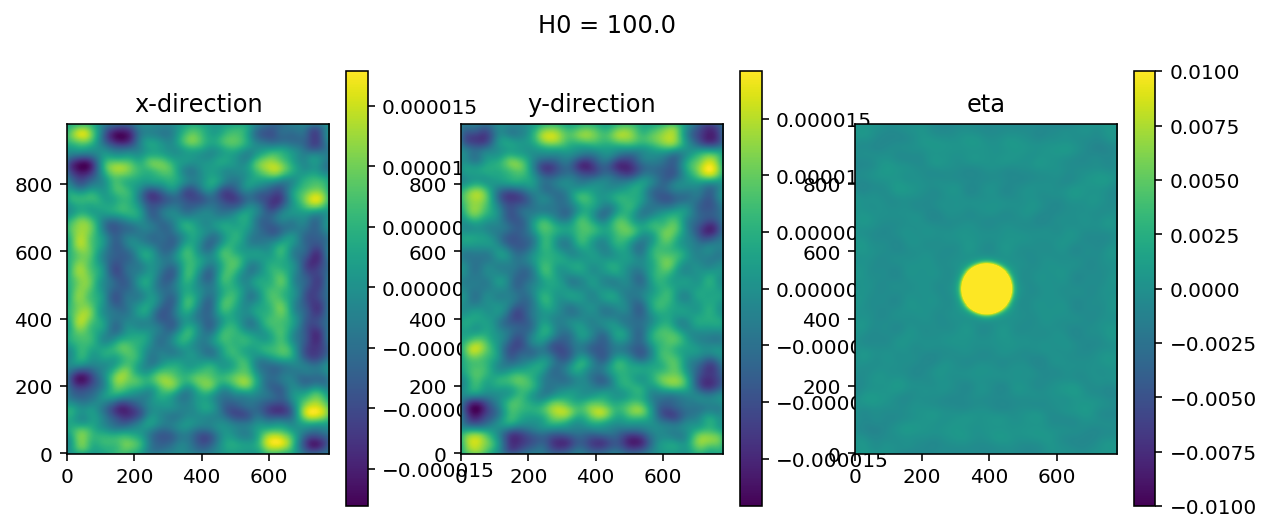

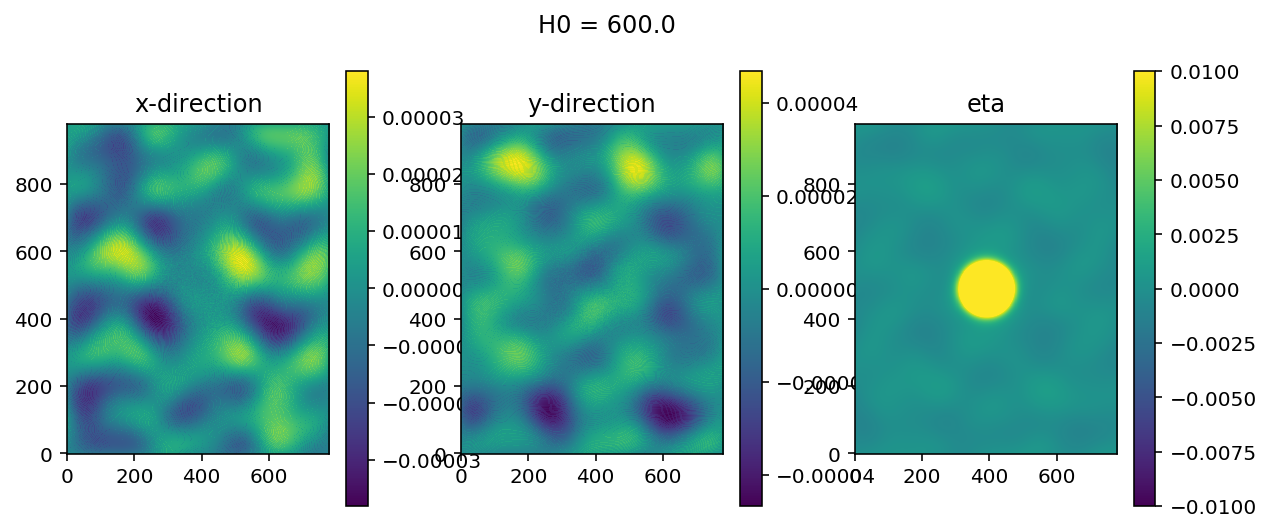

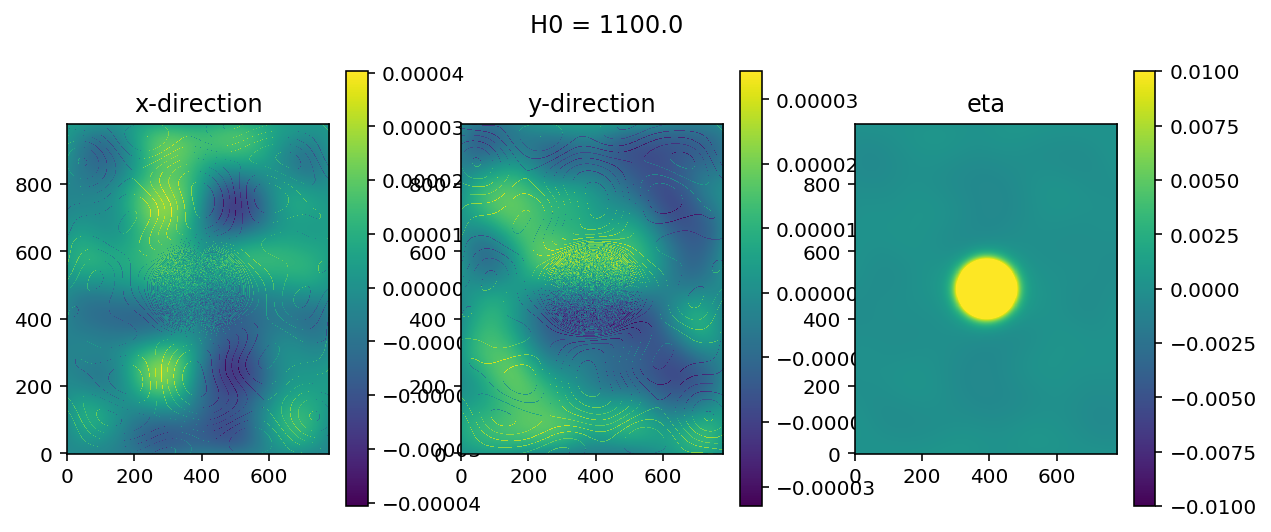

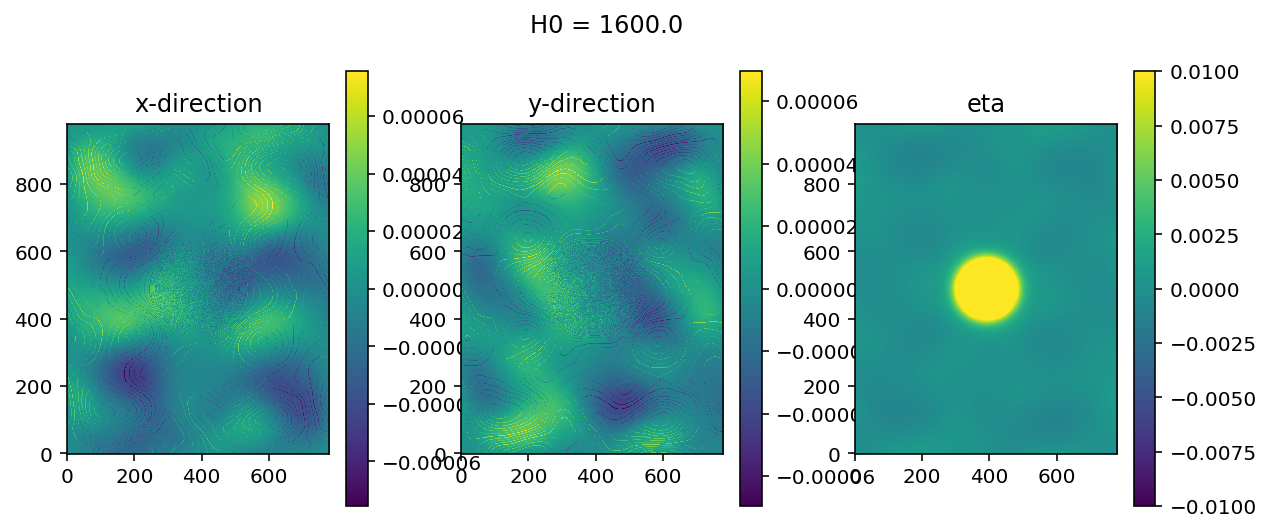

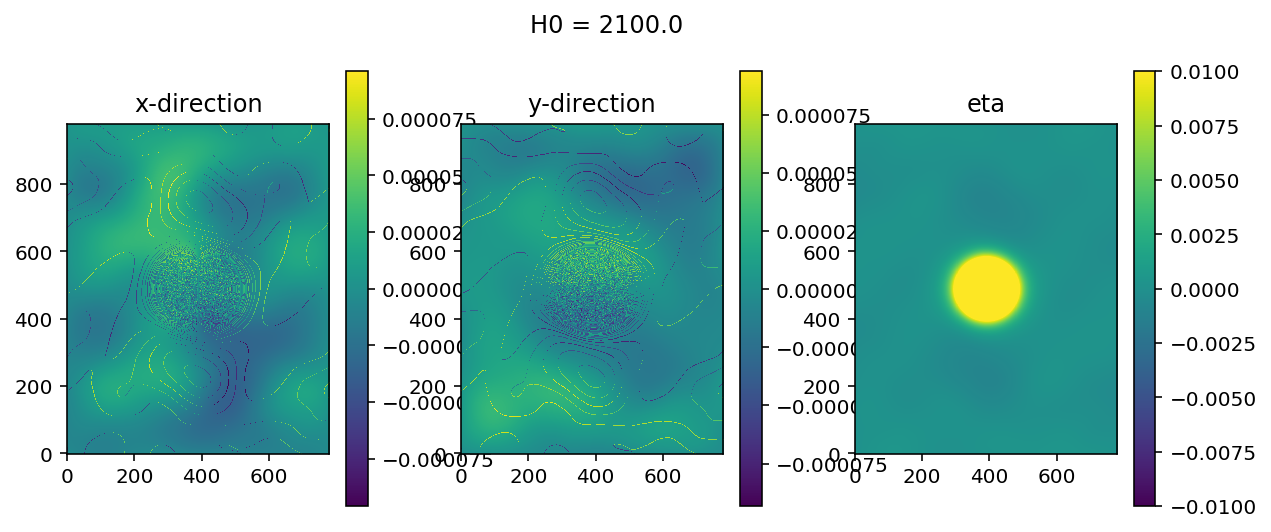

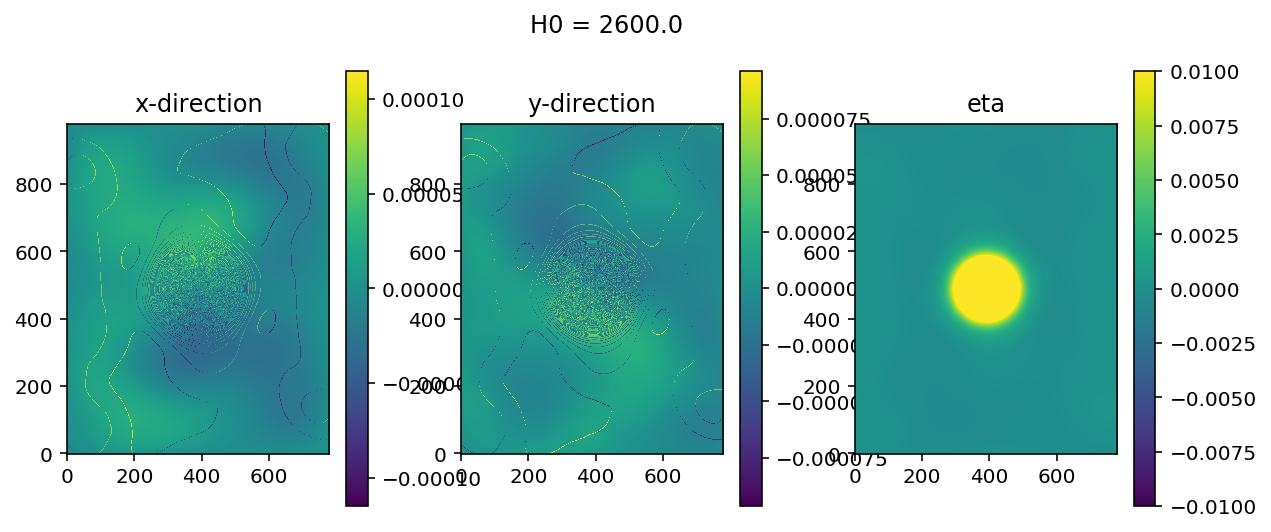

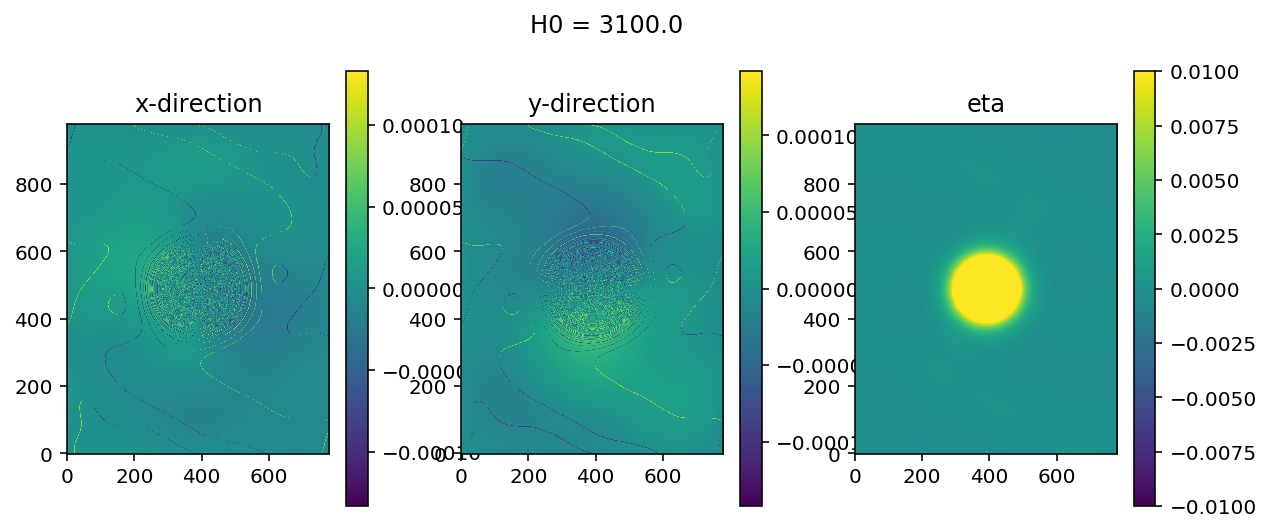

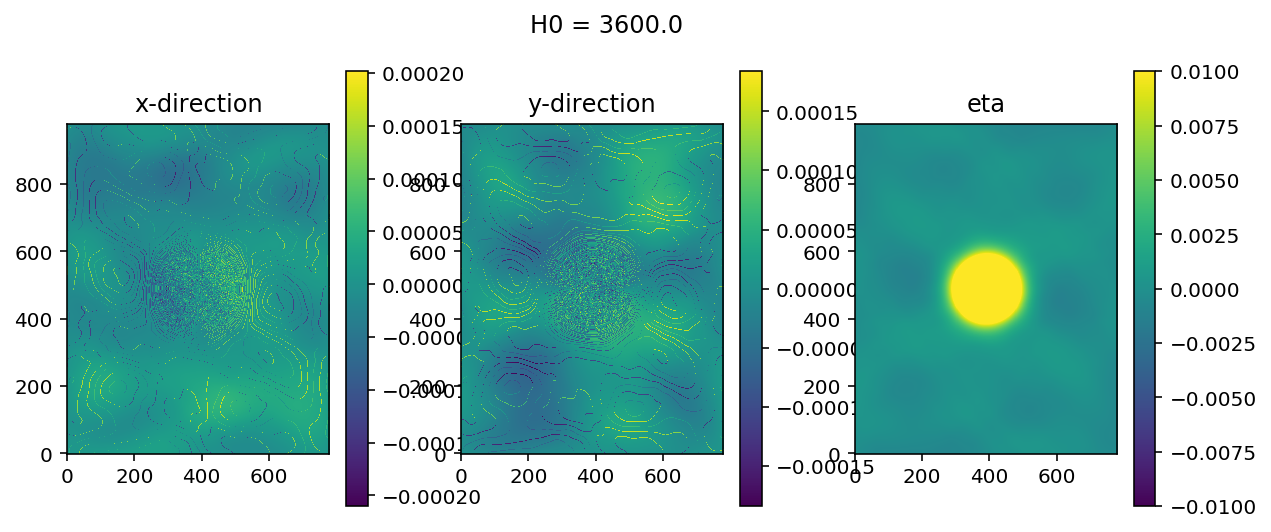

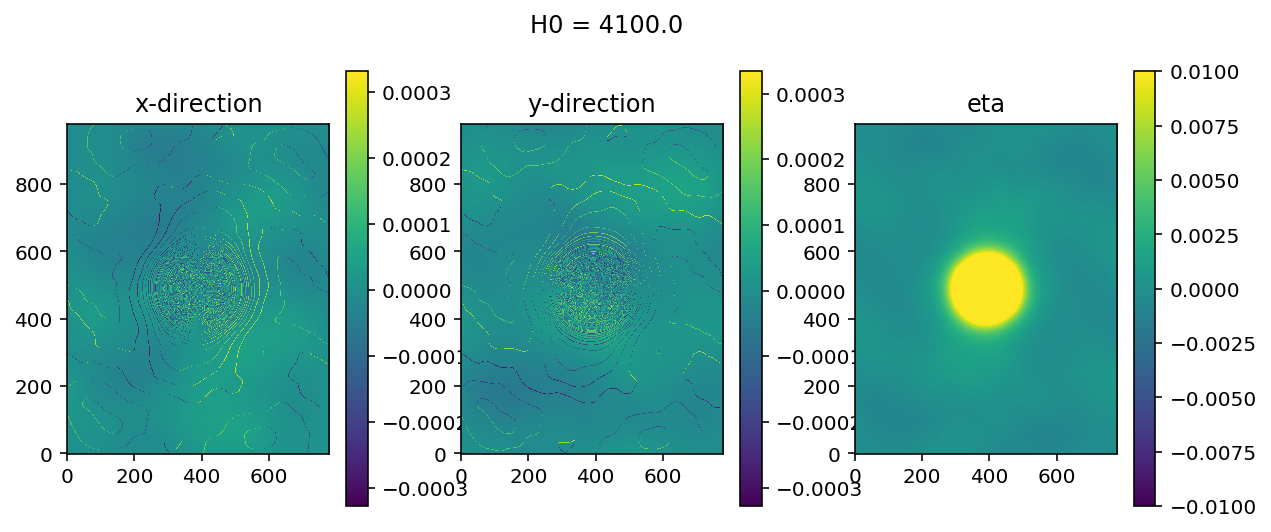

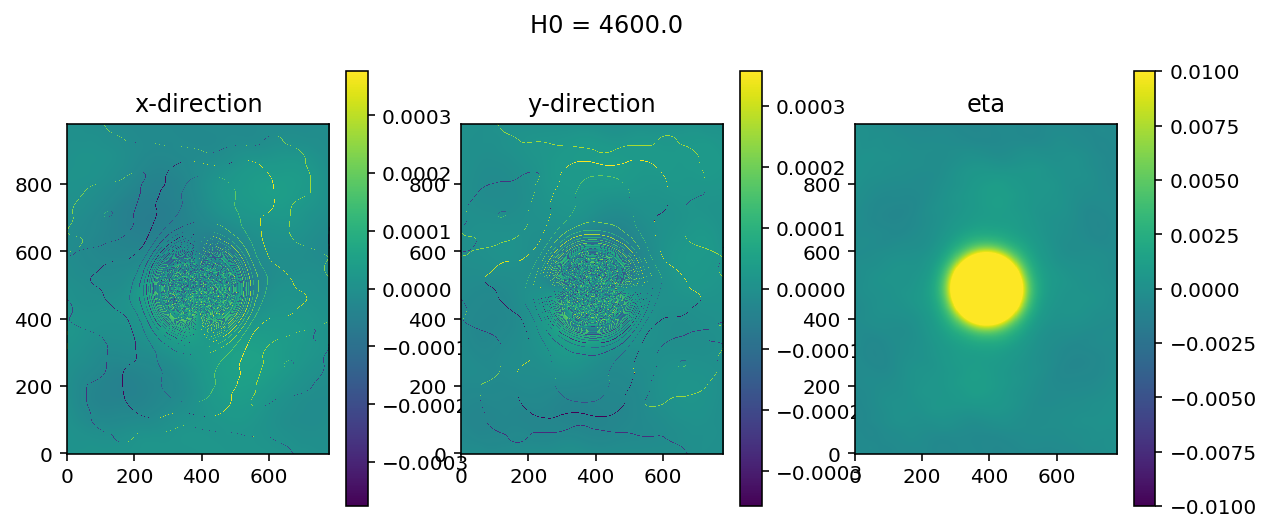

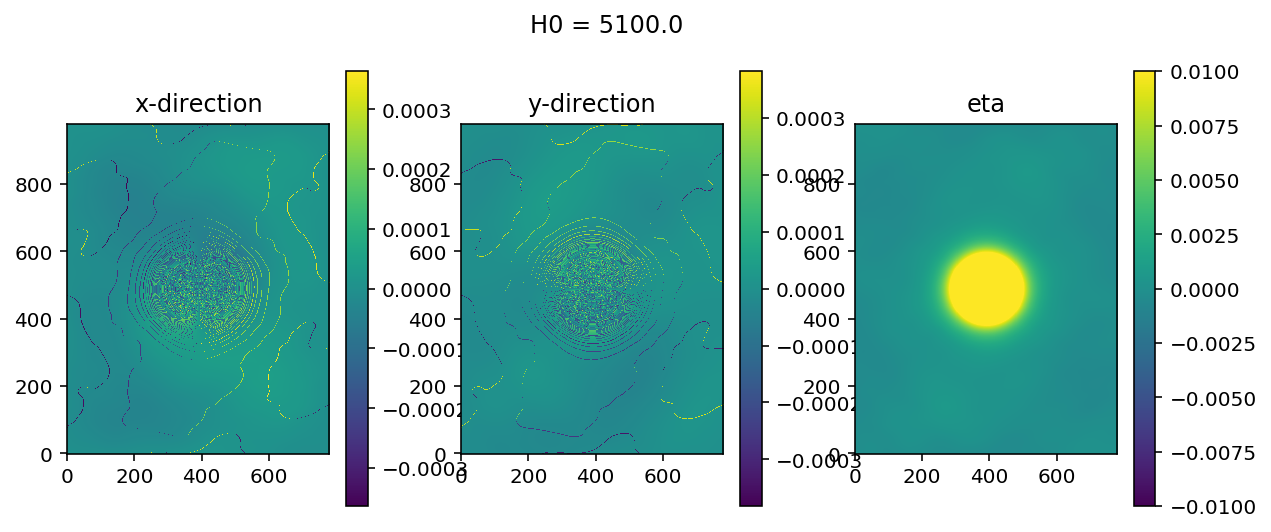

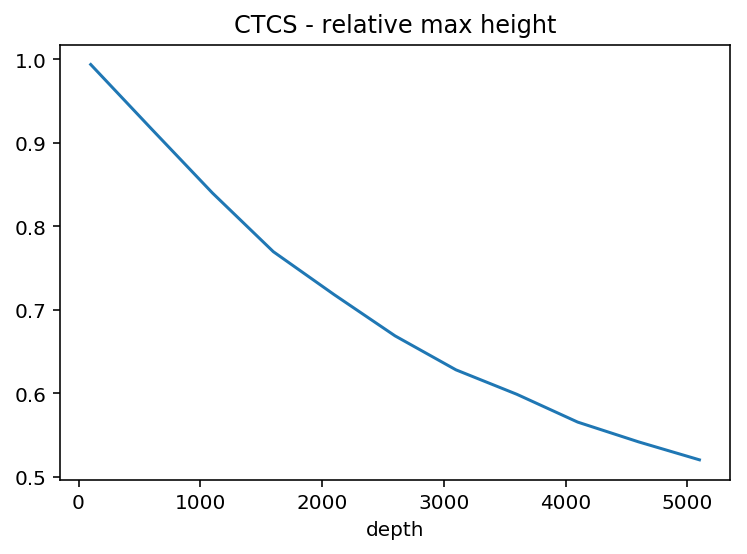

In [6]:
# Read results and find the relative eta diff
sim_rel_eta = []
sim_H = []
sim_name = 'CTCS' # FBL, CTCS, KP07 or CDKLM
sim_list = json_element[sim_name]
if (sim_name is 'KP07' or sim_name is 'CDKLM'):
    sim_list = json_fvm_element[sim_name]
for sim in sim_list:
    sim_H.append(sim['depth'])
    sim_rel_eta.append(sim['eta_max']/sim['eta_init_max'])
    
    sim_sim = SimReader.SimNetCDFReader(sim['netcdf_file_name'])
    sim_eta1, u1, v1, t = sim_sim.getLastTimeStep()
    evaluateBalance(sim_eta1, u1, v1, sim['depth'])

fig = plt.figure(figsize=(6,4))
plt.plot(sim_H, sim_rel_eta)
plt.title(sim_name + " - relative max height")
plt.xlabel("depth")

## Read reference solution from matlab output

------------------
<class 'dict'>
__header__ :  <class 'bytes'>
__version__ :  <class 'str'>
__globals__ :  <class 'list'>
A :  <class 'scipy.sparse.csc.csc_matrix'>
B :  <class 'numpy.ndarray'>
BB :  <class 'numpy.ndarray'>
D :  <class 'numpy.ndarray'>
F :  <class 'numpy.ndarray'>
H0 :  <class 'numpy.ndarray'>
HH :  <class 'numpy.ndarray'>
L :  <class 'numpy.ndarray'>
Nx :  <class 'numpy.ndarray'>
Ny :  <class 'numpy.ndarray'>
R :  <class 'numpy.ndarray'>
U :  <class 'numpy.ndarray'>
V :  <class 'numpy.ndarray'>
X :  <class 'numpy.ndarray'>
Y :  <class 'numpy.ndarray'>
a :  <class 'numpy.ndarray'>
aa :  <class 'numpy.ndarray'>
c :  <class 'numpy.ndarray'>
dx :  <class 'numpy.ndarray'>
dy :  <class 'numpy.ndarray'>
etaamp :  <class 'numpy.ndarray'>
f :  <class 'numpy.ndarray'>
g :  <class 'numpy.ndarray'>
h :  <class 'numpy.ndarray'>
hmax :  <class 'numpy.ndarray'>
ic :  <class 'numpy.ndarray'>
s :  <class 'numpy.ndarray'>
tmp :  <class 'numpy.ndarray'>
x :  <class 'numpy.ndarray'>
xH 

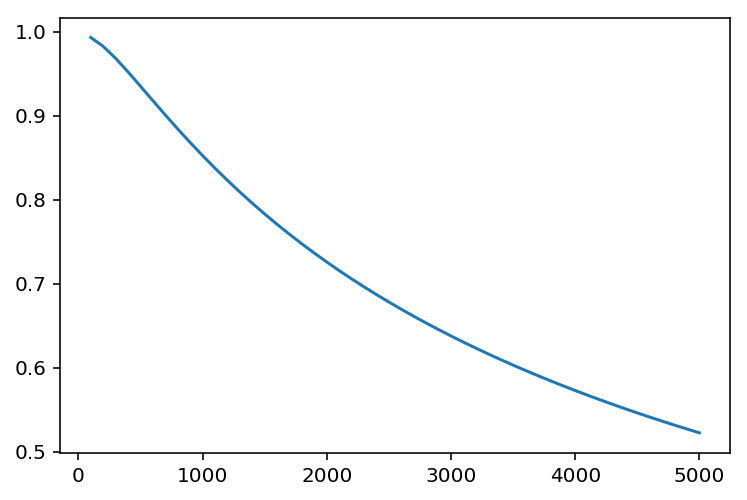

In [10]:
reference_sol_file_name = "matlab/varDepthMax.mat"
reference_sol_exists = False
if os.path.isfile(reference_sol_file_name):
    reference_sol = scipy.io.loadmat(reference_sol_file_name)
    reference_sol_exists = True
    print( "------------------")
    print( type(reference_sol))
    for key, val in reference_sol.items():
        print (key, ": ", type(val))
    #    if str(type(val)) == "<type 'numpy.ndarray'>":
    #        print "\t\t", val.shape
    #print "-------------------------"
    
    reference_hmax = reference_sol['hmax'][0,:]
    reference_H = reference_sol['HH'][0,:]
    reference_H0 = reference_sol['s']
    print( type(reference_hmax), reference_hmax.shape)
    print( type(reference_H), reference_H.shape)
    
    fig = plt.figure(figsize=(6,4))
    plt.plot(reference_H, reference_hmax)
    print( reference_H)
    print( reference_hmax)
    
    print( type(reference_H0), reference_H0.shape, np.max(reference_H0))

### Plotting

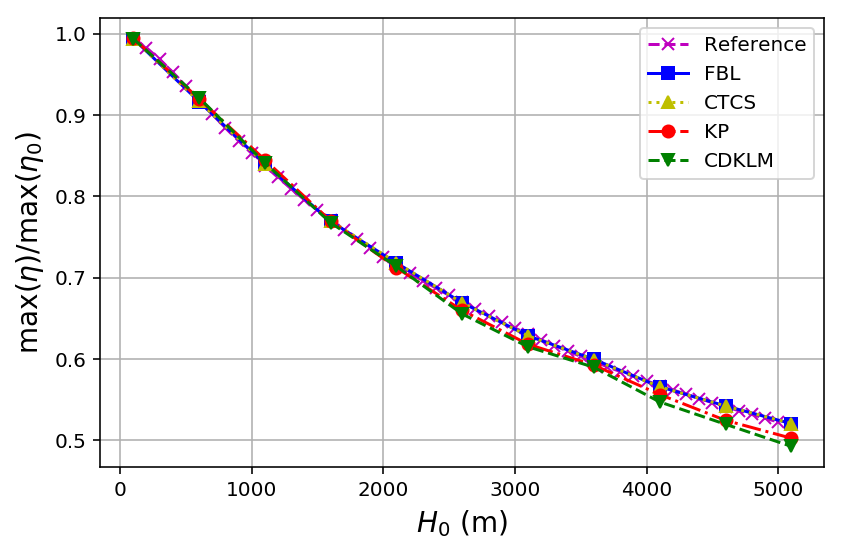

In [13]:
sim_names = ['FBL', 'CTCS', 'KP07', 'CDKLM']
ticks = ['bs-', 'y^:', 'ro-.', 'gv--']

fig = plt.figure(figsize=(6,4))
i = 0
if reference_sol_exists:
    plt.plot(reference_H, reference_hmax, 'mx--', label='Reference')
for sim_name in sim_names:
    sim_rel_eta = []
    sim_H = []
    sim_list = json_element[sim_name]
    for sim in sim_list:
        sim_H.append(sim['depth'])
        sim_rel_eta.append(sim['eta_max']/sim['eta_init_max'])
    if sim_name == 'KP07':
        sim_name = 'KP'
    plt.plot(sim_H, sim_rel_eta, ticks[i], label=sim_name)
    i = i+1
plt.xlabel("$H_0$ (m)", fontsize=14)
plt.ylabel("$\max(\eta)/\max(\eta_0)$", fontsize=14)
plt.legend()
plt.grid()
plt.tight_layout()
fig.savefig(jsondir + "rossby_adjustment_different_depths.png")
fig.savefig(jsondir + "rossby_adjustment_different_depths.pdf")

